실습 및 과제에 해당하는 내용은 [파이썬 머신러닝 완벽가이드]와 kaggle에서 참고했습니다.

kaggle 링크 : https://www.kaggle.com/competitions/bike-sharing-demand/data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# **데이터 설명**
*   datetime : hourly date + timetstamp
*   season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
*   holiday : 1 = 토, 일요일의 주말을 제외한 국격일 등의 휴일, 0 =휴일이 아닌 날
*   workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
*   weather : 1 = 맑음, 약간 구름낀 흐림, 2 = 안개, 안개 + 흐림, 3 = 가벼운 눈, 가벼운 비 + 천둥, 4 = 심한 눈/비, 천둥/번개
*   temp : 온도(섭씨)
*   atemp :체감온도(섭씨)
*   humidity : 상대 습도
*   windspeed : 풍속
*   casual : 사전에 등록되지 않는 사용자가 대여한 횟수
*   registered : 사전에 등록된 사용자가 대여한 횟수
*   count : 대여 횟수

# 데이터 불러오기

In [2]:
bike_df = pd.read_csv('bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


# Feature Engineering

기본으로 주어진 FE이외에 추가로 진행하셔도 됩니다!

In [4]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df['minute'] = bike_df.datetime.apply(lambda x : x.minute)
bike_df['second'] = bike_df.datetime.apply(lambda x : x.second)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0


In [5]:
bike_df = bike_df[bike_df['weather'] != 4]

In [6]:
drop_columns = ['casual', 'registered', 'datetime', 'month', 'windspeed']
bike_df.drop(drop_columns, axis=1, inplace=True)

# 평가지표 설정

캐글에서 요구한 성능 평가 방법은 RMSLE(Root Mean Square Log Error)입니다. 즉, 오류 값의 로그에 대한 RMSE 입니다. 사이킷런에서 직접 제공하는 함수가 없기 때문에 평가지표 함수를 만들고, 다른 평가 지표인 MSE, RMSE를 함께 모두 계산할 수 있는 함수도 추가로 만들었습니다.

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
# log1p() = 1 + log()
# 이렇게 변환된 값은 다시 expm1()함수로 쉽게 원래 스케일로 복원 가능
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

# 모델 학습/예측/평가

<AxesSubplot: >

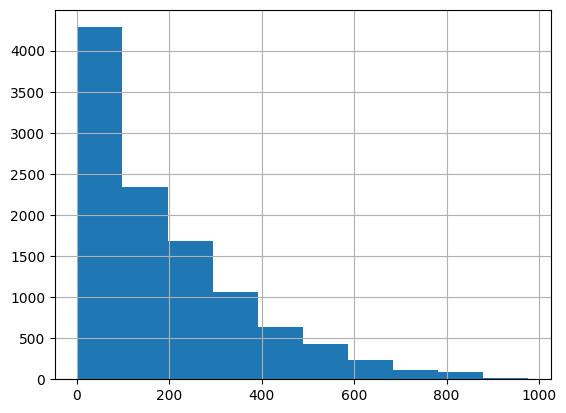

In [8]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

y_target.hist()

In [9]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
# 변환하는 이유는 count의 분포를 보게 되면 0~200 사이에 왜곡됨을 볼 수 있음.
# 정규 분포 형태로 바꾸기 위해 로그를 적용하여 변환(정규성을 높여 정확한 결과를 얻기 위함)
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.007, RMSE: 167.336, MAE: 111.181


각 feature에 대한 회귀 계숫값 시각화

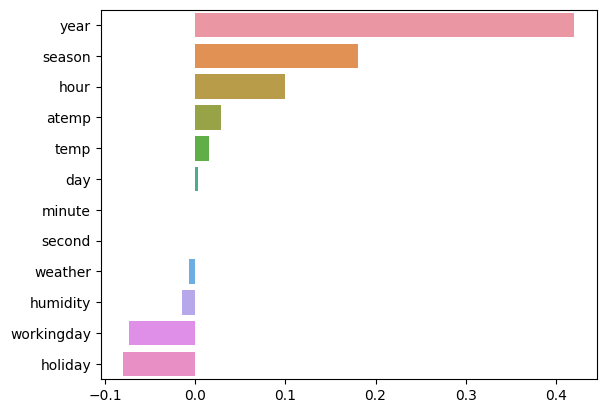

In [11]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

# one-hot encoding

In [12]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'day', 'hour', 'holiday',
                                              'workingday','season','weather'])

# one-hot encoding 후 다시 성능 평가

성능 평가를 위한 함수 생성

In [13]:
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

성능 평가 진행

In [14]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.581, RMSE: 98.645, MAE: 63.430
### Ridge ###
RMSLE: 0.582, RMSE: 99.771, MAE: 64.050
### Lasso ###
RMSLE: 0.624, RMSE: 113.963, MAE: 72.703


회귀 계수 확인

<AxesSubplot: >

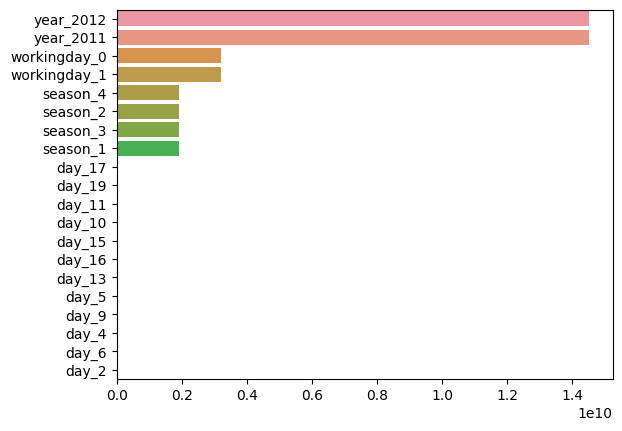

In [15]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

one-hot encoding을 통해 성능도 올라갔고, featrue 들의 영향도도 달라졌음을 알 수 있다. 항상 one-hot encoding이 성능을 올린다고 할 수는 없지만 선형 회귀의 경우 중요 카테고리성 feature들은 one-hot encoding을 하는 것이 중요한 영향을 미칠 수 있다.

# 다양한 모델을 통한 실험

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
# n_estimators를 변경할 수 있습니다. 
# 구글링을 통해 모델별로 추가 parameter 튜닝하셔도 됩니다.
rf_reg = RandomForestRegressor(n_estimators=200)
gbm_reg = GradientBoostingRegressor(n_estimators=200)
xgb_reg = XGBRegressor(n_estimators=200)
lgbm_reg = LGBMRegressor(n_estimators=200)

In [17]:
model = rf_reg  # 변경 가능

get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)
 

### RandomForestRegressor ###
RMSLE: 0.358, RMSE: 52.827, MAE: 32.478


In [18]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y_target)
gridsearch_random_forest_model.fit(bike_df, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: rmsle() takes 2 positional arguments but 3 were given

  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: rmsle() takes 2 positional arguments but 3 were given

  warnings.warn(
/opt/homebrew/lib/python3.9/site-packa

최적 하이퍼파라미터 : {'n_estimators': 100, 'random_state': 42}


In [24]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(bike_df)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(y_target_log, preds):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.0612


### 두 모델을 혼합하여 계산

여러 모델의 결과를 받고 가중치에 따른 계산을 하는 방법입니다. (단일 모델에서 가장 성능이 좋은 두 모델을 결합하였는데 더 좋지 않은 성능을 보일 수도 있습니다.)

In [25]:
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_two_models_predict(model1,model2, X_train, X_test, y_train, y_test, is_expm1=False):
    model1.fit(X_train, y_train)
    model1_pred = model1.predict(X_test)
    model2.fit(X_train, y_train)
    model2_pred = model2.predict(X_test)
    
    pred = 0.4*model1_pred + 0.6*model2_pred # 가중치 변경 가능!

    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('### Two Models ###')
    evaluate_regr(y_test, pred)

In [26]:
model1 = rf_reg  # 변경 가능
model2 = gbm_reg  # 변경 가능

get_two_models_predict(model1,model2,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)
 

### Two Models ###
RMSLE: 0.369, RMSE: 62.264, MAE: 38.729


# 과제

자유롭게 FE를 진행하시고 모델 튜닝 및 모델 선택을 진행하여서 RMSLE가 0.32 이하가 나온 것을 캡쳐해서 아래에 업로드 해주시면 됩니다. (0.32 이하가 나오지 않아도 노력한 흔적이 있으면 되기 때문에 해당 결과를 올리셔도 됩니다.)


(해당 결과는 train dataset에서 나눈 data set을 test data로 만든 것이기 때문에 실제 test 결과와는 다릅니다. 즉, 캐글 점수와는 다를 것입니다.)

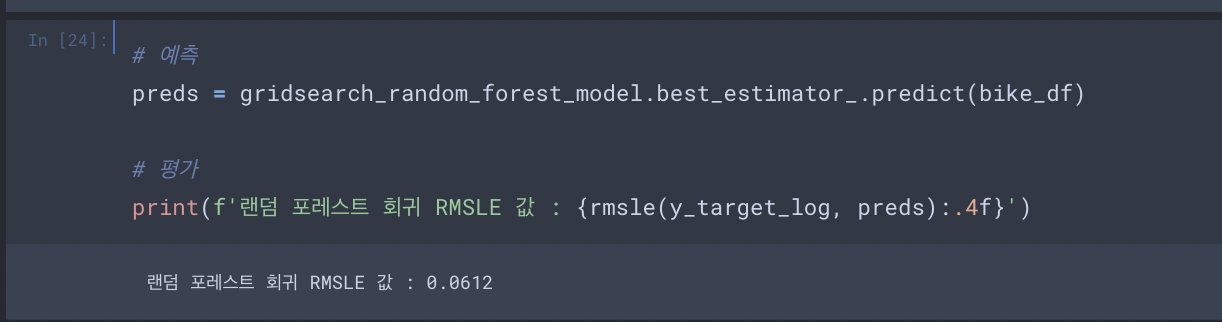